In [ ]:
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchinfo
from torchlake.few_shot.datasets.omniglot import OmniglotSet, LANGUAGES
from torchlake.few_shot.models.prototypical import (
    PrototypicalNet,
    PrototypicalNetLoss,
)
from torchvision.transforms import v2
import torchvision.transforms.functional as F
from torchlake.few_shot.controllers.trainer_prototypical import PrototypicalTrainer
from torchlake.few_shot.controllers.evaluator_prototypical import PrototypicalEvaluator
from torchlake.common.controller.recorder import TrainRecorder

# Setting

In [132]:
EPISODE_SIZE = 1000
IMAGE_SIZE = 28

In [133]:
artifact_path = Path('../../artifacts/prototypical')
data_path = Path('../../data')

In [134]:
DEVICE = torch.device("cuda:0")

# Data

In [135]:
LANGUAGES

('Alphabet_of_the_Magi',
 'Anglo-Saxon_Futhorc',
 'Arcadian',
 'Armenian',
 'Asomtavruli_(Georgian)',
 'Balinese',
 'Bengali',
 'Blackfoot_(Canadian_Aboriginal_Syllabics)',
 'Braille',
 'Burmese_(Myanmar)',
 'Cyrillic',
 'Early_Aramaic',
 'Futurama',
 'Grantha',
 'Greek',
 'Gujarati',
 'Hebrew',
 'Inuktitut_(Canadian_Aboriginal_Syllabics)',
 'Japanese_(hiragana)',
 'Japanese_(katakana)',
 'Korean',
 'Latin',
 'Malay_(Jawi_-_Arabic)',
 'Mkhedruli_(Georgian)',
 'N_Ko',
 'Ojibwe_(Canadian_Aboriginal_Syllabics)',
 'Sanskrit',
 'Syriac_(Estrangelo)',
 'Tagalog',
 'Tifinagh')

In [136]:
TRAIN_RATIO = 0.7

In [137]:
train_languages_set = set(np.random.choice(LANGUAGES, int(len(LANGUAGES) * TRAIN_RATIO), replace=False).tolist())
test_languages_set = set(LANGUAGES).difference(train_languages_set)

In [138]:
# frozen for the last training

train_languages_set = set((
    "Mkhedruli_(Georgian)",
    "Gujarati",
    "Sanskrit",
    "Arcadian",
    "N_Ko",
    "Balinese",
    "Malay_(Jawi_-_Arabic)",
    "Early_Aramaic",
    "Inuktitut_(Canadian_Aboriginal_Syllabics)",
    "Latin",
    "Burmese_(Myanmar)",
    "Anglo-Saxon_Futhorc",
    "Blackfoot_(Canadian_Aboriginal_Syllabics)",
    "Asomtavruli_(Georgian)",
    "Armenian",
    "Hebrew",
    "Braille",
    "Alphabet_of_the_Magi",
    "Grantha",
    "Syriac_(Estrangelo)",
    "Greek",
))
test_languages_set = set(LANGUAGES).difference(train_languages_set)

In [139]:
preprocess = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    # lambda x: F.rotate(x, random.choice(range(0, 360, 90))),
    v2.ToTensor(),
])

d:\research\pytorch-implementations\gits\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [140]:
train_dataset = OmniglotSet(
    data_path,
    languages=tuple(train_languages_set),
    transform=preprocess,
    enable_episode=True,
    way_size=5,
    shot_size=5,
    query_size=15,
    episode_size=EPISODE_SIZE,
)

In [141]:
print(f"{'lang':>50}   char count")
print("-" * 80)
for lang, chars in train_dataset.lang_chars.items():
    print(f"{lang:>50}   {len(chars)}")

                                              lang   char count
--------------------------------------------------------------------------------
                              Mkhedruli_(Georgian)   41
                                          Gujarati   48
                                          Sanskrit   42
                                          Arcadian   26
                                              N_Ko   33
                                          Balinese   24
                             Malay_(Jawi_-_Arabic)   40
                                     Early_Aramaic   22
         Inuktitut_(Canadian_Aboriginal_Syllabics)   16
                                             Latin   26
                                 Burmese_(Myanmar)   34
                               Anglo-Saxon_Futhorc   29
         Blackfoot_(Canadian_Aboriginal_Syllabics)   14
                            Asomtavruli_(Georgian)   40
                                          Armenian   41
               

# model

In [ ]:
model = PrototypicalNet(1, hidden_dim=64, num_layer=4).to(DEVICE)

In [143]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
PrototypicalNetwork                      --
├─Sequential: 1-1                        --
│    └─Conv2dNormActivation: 2-1         --
│    │    └─Conv2d: 3-1                  576
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    └─MaxPool2d: 2-2                    --
├─Sequential: 1-2                        --
│    └─Conv2dNormActivation: 2-3         --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    │    └─ReLU: 3-6                    --
│    └─MaxPool2d: 2-4                    --
│    └─Conv2dNormActivation: 2-5         --
│    │    └─Conv2d: 3-7                  36,864
│    │    └─BatchNorm2d: 3-8             128
│    │    └─ReLU: 3-9                    --
│    └─MaxPool2d: 2-6                    --
│    └─Conv2dNormActivation: 2-7         --
│    │    └─Conv2d: 3-10                 36,864
│    │    └─BatchNorm2d: 3-11            128
│    │    

# training

In [144]:
EPOCH = 30

In [145]:
trainer = PrototypicalTrainer()

In [146]:
recorder = TrainRecorder(total_epoch=EPOCH)
recorder.increment_data_size(EPISODE_SIZE)

In [ ]:
criterion = PrototypicalNetLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [148]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, threshold=.05 ,threshold_mode ='rel')

In [149]:
training_loss = trainer.run(
    train_dataset,
    model,
    optimizer,
    criterion,
    recorder=recorder,
    scheduler=scheduler,
)

Enable AMP: False
Training...


100%|██████████| 1000/1000 [01:17<00:00, 12.82it/s]


------------------------------------
Epoch 1
------------------------------------
total: 9.8697e-02 (0.00%)


100%|██████████| 1000/1000 [01:16<00:00, 13.01it/s]


------------------------------------
Epoch 2
------------------------------------
total: 3.8455e-02 (-61.00%)


100%|██████████| 1000/1000 [01:16<00:00, 13.09it/s]


------------------------------------
Epoch 3
------------------------------------
total: 2.6035e-02 (-32.00%)


100%|██████████| 1000/1000 [01:14<00:00, 13.36it/s]


------------------------------------
Epoch 4
------------------------------------
total: 2.2982e-02 (-12.00%)


100%|██████████| 1000/1000 [01:15<00:00, 13.31it/s]


------------------------------------
Epoch 5
------------------------------------
total: 2.7881e-02 (21.00%)


100%|██████████| 1000/1000 [01:14<00:00, 13.48it/s]


------------------------------------
Epoch 6
------------------------------------
total: 2.1306e-02 (-24.00%)


100%|██████████| 1000/1000 [01:14<00:00, 13.47it/s]


------------------------------------
Epoch 7
------------------------------------
total: 1.8394e-02 (-14.00%)


100%|██████████| 1000/1000 [01:24<00:00, 11.87it/s]


------------------------------------
Epoch 8
------------------------------------
total: 1.8602e-02 (1.00%)


100%|██████████| 1000/1000 [01:31<00:00, 10.89it/s]


------------------------------------
Epoch 9
------------------------------------
total: 1.6305e-02 (-12.00%)


100%|██████████| 1000/1000 [01:32<00:00, 10.86it/s]


------------------------------------
Epoch 10
------------------------------------
total: 1.6192e-02 (-1.00%)


100%|██████████| 1000/1000 [01:30<00:00, 11.11it/s]


------------------------------------
Epoch 11
------------------------------------
total: 1.9022e-02 (17.00%)


100%|██████████| 1000/1000 [01:30<00:00, 10.99it/s]


------------------------------------
Epoch 12
------------------------------------
total: 1.7995e-02 (-5.00%)


100%|██████████| 1000/1000 [01:32<00:00, 10.76it/s]


------------------------------------
Epoch 13
------------------------------------
total: 1.4358e-02 (-20.00%)


100%|██████████| 1000/1000 [01:35<00:00, 10.48it/s]


------------------------------------
Epoch 14
------------------------------------
total: 1.4817e-02 (3.00%)


100%|██████████| 1000/1000 [01:23<00:00, 12.00it/s]


------------------------------------
Epoch 15
------------------------------------
total: 1.7232e-02 (16.00%)


100%|██████████| 1000/1000 [01:16<00:00, 13.14it/s]


------------------------------------
Epoch 16
------------------------------------
total: 1.8306e-02 (6.00%)


100%|██████████| 1000/1000 [01:20<00:00, 12.38it/s]


------------------------------------
Epoch 17
------------------------------------
total: 1.6253e-02 (-11.00%)


100%|██████████| 1000/1000 [01:22<00:00, 12.12it/s]


------------------------------------
Epoch 18
------------------------------------
total: 1.7115e-02 (5.00%)


100%|██████████| 1000/1000 [01:31<00:00, 10.87it/s]


------------------------------------
Epoch 19
------------------------------------
total: 1.0893e-02 (-36.00%)


100%|██████████| 1000/1000 [01:34<00:00, 10.56it/s]


------------------------------------
Epoch 20
------------------------------------
total: 1.4429e-02 (32.00%)


100%|██████████| 1000/1000 [01:34<00:00, 10.55it/s]


------------------------------------
Epoch 21
------------------------------------
total: 1.5943e-02 (10.00%)


100%|██████████| 1000/1000 [01:28<00:00, 11.30it/s]


------------------------------------
Epoch 22
------------------------------------
total: 1.5812e-02 (-1.00%)


100%|██████████| 1000/1000 [01:35<00:00, 10.43it/s]


------------------------------------
Epoch 23
------------------------------------
total: 1.4935e-02 (-6.00%)


100%|██████████| 1000/1000 [01:31<00:00, 10.99it/s]


------------------------------------
Epoch 24
------------------------------------
total: 1.2954e-02 (-13.00%)


100%|██████████| 1000/1000 [01:17<00:00, 12.97it/s]


------------------------------------
Epoch 25
------------------------------------
total: 1.5478e-02 (19.00%)


100%|██████████| 1000/1000 [01:19<00:00, 12.63it/s]


------------------------------------
Epoch 26
------------------------------------
total: 1.1204e-02 (-28.00%)


100%|██████████| 1000/1000 [01:20<00:00, 12.44it/s]


------------------------------------
Epoch 27
------------------------------------
total: 1.2643e-02 (13.00%)


100%|██████████| 1000/1000 [01:20<00:00, 12.39it/s]


------------------------------------
Epoch 28
------------------------------------
total: 1.3145e-02 (4.00%)


100%|██████████| 1000/1000 [01:17<00:00, 12.85it/s]


------------------------------------
Epoch 29
------------------------------------
total: 1.0717e-02 (-18.00%)


100%|██████████| 1000/1000 [01:17<00:00, 12.84it/s]

------------------------------------
Epoch 30
------------------------------------
total: 8.7907e-03 (-18.00%)


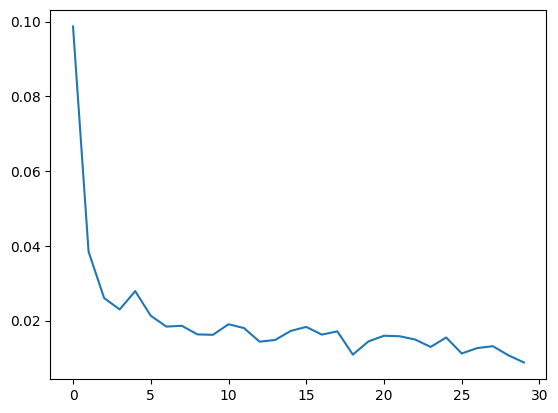

In [150]:
plt.plot(training_loss)

# evaluation

In [151]:
test_preprocess = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    v2.ToTensor(),
])

## 5-way, one shot & few shot

### 1 shot

In [178]:
test_dataset = OmniglotSet(
    data_path,
    languages=tuple(test_languages_set),
    transform=test_preprocess,
    enable_episode=True,
    way_size=5,
    shot_size=1,
    query_size=1,
    episode_size=600,
)

In [179]:
evaluator = PrototypicalEvaluator(5, DEVICE, reduction="min")
confusion_matrix = evaluator.run(test_dataset, model)
evaluator.get_total_accuracy(confusion_matrix)

100%|██████████| 600/600 [00:06<00:00, 86.84it/s]


array(0.97466667)

### 5 shot

In [176]:
test_dataset = OmniglotSet(
    data_path,
    languages=tuple(test_languages_set),
    transform=test_preprocess,
    enable_episode=True,
    way_size=5,
    shot_size=5,
    query_size=1,
    episode_size=600,
)

In [177]:
evaluator = PrototypicalEvaluator(5, DEVICE, reduction="min")
confusion_matrix = evaluator.run(test_dataset, model)
evaluator.get_total_accuracy(confusion_matrix)

100%|██████████| 600/600 [00:13<00:00, 42.92it/s]


array(0.988)

## all chars

In [152]:
WAY_SIZE = len(OmniglotSet(data_path, languages=tuple(test_languages_set)).char_paths)
WAY_SIZE

330

In [153]:
test_dataset = OmniglotSet(
    data_path,
    languages=tuple(test_languages_set),
    transform=test_preprocess,
    enable_episode=True,
    way_size=WAY_SIZE,
    shot_size=5,
    query_size=1,
    episode_size=600,
)

In [154]:
print(f"{'lang':>50}   char count")
print("-" * 80)
for lang, chars in test_dataset.lang_chars.items():
    print(f"{lang:>50}   {len(chars)}")

                                              lang   char count
--------------------------------------------------------------------------------
                                          Tifinagh   55
                               Japanese_(hiragana)   52
                                           Bengali   46
                                          Cyrillic   33
                                            Korean   40
                                          Futurama   26
                                           Tagalog   17
            Ojibwe_(Canadian_Aboriginal_Syllabics)   14
                               Japanese_(katakana)   47


In [155]:
evaluator = PrototypicalEvaluator(WAY_SIZE, DEVICE, reduction="min")

In [156]:
confusion_matrix = evaluator.run(test_dataset, model)

100%|██████████| 600/600 [11:52<00:00,  1.19s/it]


In [157]:
evaluator.get_total_accuracy(confusion_matrix)

array(0.56364646)

## average languages

### 1 shot

In [172]:
accs = []

In [173]:
for lang in tuple(test_languages_set):
    WAY_SIZE = len(OmniglotSet(data_path, languages=(lang,)).char_paths)

    test_dataset = OmniglotSet(
        data_path,
        languages=(lang,),
        transform=test_preprocess,
        enable_episode=True,
        way_size=WAY_SIZE,
        shot_size=1,
        query_size=1,
        episode_size=600,
    )

    evaluator = PrototypicalEvaluator(WAY_SIZE, DEVICE, reduction="min")
    confusion_matrix = evaluator.run(test_dataset, model)
    acc = evaluator.get_total_accuracy(confusion_matrix)
    accs.append(acc)

100%|██████████| 600/600 [00:44<00:00, 13.44it/s]


In [174]:
np.mean(accs)

np.float64(0.5385204576913236)

In [175]:
print(f"{'lang':>50}   acc")
print("-" * 80)
for lang, acc in zip(test_languages_set, accs):
    print(f"{lang:>50}   {acc.round(4)}")

                                              lang   acc
--------------------------------------------------------------------------------
                                          Tifinagh   0.5872
                               Japanese_(hiragana)   0.5036
                                           Bengali   0.4855
                                          Cyrillic   0.5955
                                            Korean   0.5533
                                          Futurama   0.5521
                                           Tagalog   0.5385
            Ojibwe_(Canadian_Aboriginal_Syllabics)   0.5677
                               Japanese_(katakana)   0.4633


### 5 shot

In [159]:
accs = []

In [160]:
for lang in tuple(test_languages_set):
    WAY_SIZE = len(OmniglotSet(data_path, languages=(lang,)).char_paths)

    test_dataset = OmniglotSet(
        data_path,
        languages=(lang,),
        transform=test_preprocess,
        enable_episode=True,
        way_size=WAY_SIZE,
        shot_size=5,
        query_size=1,
        episode_size=600,
    )

    evaluator = PrototypicalEvaluator(WAY_SIZE, DEVICE, reduction="min")
    confusion_matrix = evaluator.run(test_dataset, model)
    acc = evaluator.get_total_accuracy(confusion_matrix)
    accs.append(acc)

100%|██████████| 600/600 [01:59<00:00,  5.03it/s]


In [161]:
np.mean(accs)

np.float64(0.592870204154595)

In [167]:
print(f"{'lang':>50}   acc")
print("-" * 80)
for lang, acc in zip(test_languages_set, accs):
    print(f"{lang:>50}   {acc.round(4)}")

                                              lang   acc
--------------------------------------------------------------------------------
                                          Tifinagh   0.6172
                               Japanese_(hiragana)   0.5799
                                           Bengali   0.5653
                                          Cyrillic   0.6173
                                            Korean   0.6048
                                          Futurama   0.6124
                                           Tagalog   0.6009
            Ojibwe_(Canadian_Aboriginal_Syllabics)   0.5851
                               Japanese_(katakana)   0.5529


# save

In [163]:
model_path = artifact_path / 'prototypical.pth'

In [164]:
torch.save(model.state_dict(), model_path)

In [165]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>